# Import libraries

In [2]:
import os
import warnings
import itertools
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy import signal
from scipy import stats
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn import preprocessing 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

# warnings.simplefilter('ignore', pd.core.common.SettingWithCopyWarning)
warnings.simplefilter("ignore")


# Define functions

In [4]:
def time_embed(df, lag):
    lagged_df = df.copy()[lag:].reset_index(drop=True)
    for l in range(1, lag+1):
        lagged_df = pd.merge(lagged_df, df[lag-l:-l].reset_index(drop=True), left_index=True, right_index=True,suffixes=("", "_Lag:{}".format(l)))
    return lagged_df


# Initialize variables

In [6]:
training_data_folder = "training data"
training_user_folders = [f for f in os.listdir(training_data_folder) if os.path.isdir(os.path.join(training_data_folder, f))] # Get list of all user folders for trining
oos_data_folder = "Out-of-sample data"
oos_user_folders = [f for f in os.listdir(oos_data_folder) if os.path.isdir(os.path.join(oos_data_folder, f))] # Get list of all user folders for oos
dfs = [] # Create an empty list to store DataFrames for all user
lag = 9
window_size = 13
K = 0.8 # fraction of data for training (1-K will be used for cross validation)
L = 0.15 # distance of IMU1 from wrist joint
H = 0.05 # distance of IMU2 from wrist joint
pitch_bins = np.linspace(-54, 60, 115) # based on Ryu et al. 1991, The Journal of Hand Surgery
yaw_bins = np.linspace(-17, 40, 58) # based on Ryu et al. 1991, The Journal of Hand Surgery


# Feature extraction

In [10]:
# Iterate over each user folder
for user_id in np.arange(len(training_user_folders)):
    user_data_folder = training_data_folder+"/User-"+str(user_id)
    # print( "user "+str(user_id))
    # print(user_data_folder)

    # Load CSV files for each user
    df_falcon = pd.read_csv(os.path.join(user_data_folder, "novint-falcon.csv"))
    df_falcon = df_falcon.rename(columns={'global time': 'Time'}) # rename time column for consistency
    df_imu = pd.read_csv(os.path.join(user_data_folder, "imu.csv"))
    df_angles = pd.read_csv(os.path.join(user_data_folder, "wrist-angles.csv"))
    df_img = pd.read_csv(os.path.join(user_data_folder, "IMG_2 (Instance).csv"))
    
    # Convert time columns to datetime format
    df_falcon['Time'] = pd.to_datetime(df_falcon['Time'].str.strip(), format='%H:%M:%S.%f')
    df_imu['Time'] = pd.to_datetime(df_imu['Time'])
    df_angles['Time'] = pd.to_datetime(df_angles['Time'].str.strip(), format='%I:%M:%S.%f %p')

    # Extract the time from the first row of df_img
    start_time_img = df_img.iloc[0][' time (s)']

    # Find the index of the exact time in df_falcon
    exact_index_falcon = df_falcon[df_falcon[' time (s)'] == start_time_img].index[0]

    # Slice df_falcon from the exact index
    df_falcon = df_falcon.iloc[exact_index_falcon:].reset_index(drop=True)

    # Calculate the time difference for df_angles and df_imu
    time_diff_angles = abs(df_angles['Time'] - df_falcon.iloc[0]['Time'])
    time_diff_imu = abs(df_imu['Time'] - df_falcon.iloc[0]['Time'])

    # Find the index of the minimum time difference
    nearest_index_angles = time_diff_angles.idxmin()
    nearest_index_imu = time_diff_imu.idxmin()

    # Slice df_angles and df_imu from the nearest index
    df_angles = df_angles.iloc[nearest_index_angles:].reset_index()
    df_imu = df_imu.iloc[nearest_index_imu:].reset_index()

    # # Number of raw observsations in each dataset
    # print("falcon observations = "+str(np.shape(df_falcon)[0]))
    # print("imu observations = "+str(np.shape(df_imu)[0]))
    
    # Subset only columns relevant for training
    df_falcon = df_falcon.drop([' time (s)',' rotation_x',' rotation_y'], axis=1)
    df_imu.drop(list(df_imu.filter(regex='2')), axis=1, inplace=True) # remove anything with IMU2 that is placed on the back of the hand

    # Downsample the falcon data
    df_falcon_downsampled = pd.DataFrame(columns=df_falcon.keys())
    for ts in np.arange(len(df_angles)):
        min_index = abs(df_angles.iloc[ts]['Time'] - df_falcon['Time']).idxmin()
        df_falcon_downsampled.loc[len(df_falcon_downsampled.index)] = df_falcon.iloc[min_index-2:min_index+3][[' falcon_x',' falcon_y',' falcon_z']].mean()
    df_falcon = pd.concat([df_angles['Time'],df_falcon_downsampled.drop('Time', axis=1).reset_index(drop=True)], axis=1)

    # remove drift from IMU1 yaw
    m,b = np.polyfit(np.arange(np.shape(df_imu)[0]), df_imu["Yaw1"], 1)
    df_imu["Yaw1"] = df_imu["Yaw1"]-(m*np.arange(np.shape(df_imu)[0])+b)    

    # apply a median filter on all raw data
    df_angles["Roll"] = signal.medfilt(df_angles["Roll"],kernel_size=window_size)
    df_angles["Pitch"] = signal.medfilt(df_angles["Pitch"],kernel_size=window_size)
    df_angles["Yaw"] = signal.medfilt(df_angles["Yaw"],kernel_size=window_size)
    df_falcon[" falcon_x"] = signal.medfilt(df_falcon[" falcon_x"],kernel_size=window_size)
    df_falcon[" falcon_y"] = signal.medfilt(df_falcon[" falcon_y"],kernel_size=window_size)
    df_falcon[" falcon_z"] = signal.medfilt(df_falcon[" falcon_z"],kernel_size=window_size)
    df_imu["Yaw1"] = signal.medfilt(df_imu["Yaw1"],kernel_size=window_size)
    df_imu["Pitch1"] = signal.medfilt(df_imu["Pitch1"],kernel_size=window_size)
    df_imu["Roll1"] = signal.medfilt(df_imu["Roll1"],kernel_size=window_size)
    df_imu["AccX1"] = signal.medfilt(df_imu["AccX1"],kernel_size=window_size)
    df_imu["AccY1"] = signal.medfilt(df_imu["AccY1"],kernel_size=window_size)
    df_imu["AccZ1"] = signal.medfilt(df_imu["AccZ1"],kernel_size=window_size)
    df_imu["RotX1"] = signal.medfilt(df_imu["RotX1"],kernel_size=window_size)
    df_imu["RotY1"] = signal.medfilt(df_imu["RotY1"],kernel_size=window_size)
    df_imu["RotZ1"] = signal.medfilt(df_imu["RotZ1"],kernel_size=window_size)

    # add time derivatives in falcon data
    df_falcon["falcon_x_dot"] = df_falcon[" falcon_x"]
    df_falcon["falcon_y_dot"] = df_falcon[" falcon_y"]
    df_falcon["falcon_z_dot"] = df_falcon[" falcon_z"]
    for ts in np.arange(((window_size-1)/2),len(df_falcon)-((window_size-1)/2)):
        df_falcon.loc[ts, 'falcon_x_dot'] = (df_falcon[" falcon_x"].loc[ts+((window_size-1)/2)]-df_falcon[" falcon_x"].loc[ts-((window_size-1)/2)])/(df_falcon["Time"].loc[ts+((window_size-1)/2)]-df_falcon["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_falcon.loc[ts, 'falcon_y_dot'] = (df_falcon[" falcon_y"].loc[ts+((window_size-1)/2)]-df_falcon[" falcon_y"].loc[ts-((window_size-1)/2)])/(df_falcon["Time"].loc[ts+((window_size-1)/2)]-df_falcon["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_falcon.loc[ts, 'falcon_z_dot'] = (df_falcon[" falcon_z"].loc[ts+((window_size-1)/2)]-df_falcon[" falcon_z"].loc[ts-((window_size-1)/2)])/(df_falcon["Time"].loc[ts+((window_size-1)/2)]-df_falcon["Time"].loc[ts-((window_size-1)/2)]).total_seconds()

    # add time integrals in IMU data
    df_imu["VelX1"] = df_imu["AccX1"]
    df_imu["VelY1"] = df_imu["AccY1"]
    df_imu["VelZ1"] = df_imu["AccZ1"]    
    for ts in np.arange(((window_size-1)/2),len(df_imu)-((window_size-1)/2)):
        df_imu.loc[ts,'VelX1'] = (df_imu["AccX1"].loc[ts+((window_size-1)/2)]-df_imu["AccX1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_imu.loc[ts,'VelY1'] = (df_imu["AccY1"].loc[ts+((window_size-1)/2)]-df_imu["AccY1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_imu.loc[ts,'VelZ1'] = (df_imu["AccZ1"].loc[ts+((window_size-1)/2)]-df_imu["AccZ1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
    
    # add time integrals in IMU data
    df_imu["PosX1"] = df_imu["AccX1"]
    df_imu["PosY1"] = df_imu["AccY1"]
    df_imu["PosZ1"] = df_imu["AccZ1"]    
    for ts in np.arange(((window_size-1)/2),len(df_imu)-((window_size-1)/2)):
        df_imu.loc[ts,'PosX1'] = (df_imu["VelX1"].loc[ts+((window_size-1)/2)]-df_imu["VelX1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_imu.loc[ts,'PosY1'] = (df_imu["VelY1"].loc[ts+((window_size-1)/2)]-df_imu["VelY1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_imu.loc[ts,'PosZ1'] = (df_imu["VelZ1"].loc[ts+((window_size-1)/2)]-df_imu["VelZ1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()

    # add features from the kinematic model
    df_imu["sin(Pitch1)"] = np.sin(df_imu["Pitch1"].astype(float).apply(math.radians))
    df_imu["sin(Yaw1)"] = np.sin(df_imu["Yaw1"].astype(float).apply(math.radians))
    df_imu["sin(Roll1)"] = np.sin(df_imu["Roll1"].astype(float).apply(math.radians))
    df_imu["cos(Pitch1)"] = np.cos(df_imu["Pitch1"].astype(float).apply(math.radians))
    df_imu["cos(Yaw1)"] = np.cos(df_imu["Yaw1"].astype(float).apply(math.radians))
    df_imu["cos(Roll1)"] = np.cos(df_imu["Roll1"].astype(float).apply(math.radians))
    df_imu["RotX1*sin(Pitch1)"] = df_imu["RotX1"]*df_imu["sin(Pitch1)"]
    df_imu["RotY1*sin(Pitch1)"] = df_imu["RotY1"]*df_imu["sin(Pitch1)"]
    df_imu["RotZ1*sin(Pitch1)"] = df_imu["RotZ1"]*df_imu["sin(Pitch1)"]
    df_imu["RotX1*sin(Yaw1)"] = df_imu["RotX1"]*df_imu["sin(Yaw1)"]
    df_imu["RotY1*sin(Yaw1)"] = df_imu["RotY1"]*df_imu["sin(Yaw1)"]
    df_imu["RotZ1*sin(Yaw1)"] = df_imu["RotZ1"]*df_imu["sin(Yaw1)"]
    df_imu["RotX1*sin(Roll1)"] = df_imu["RotX1"]*df_imu["sin(Roll1)"]
    df_imu["RotY1*sin(Roll1)"] = df_imu["RotY1"]*df_imu["sin(Roll1)"]
    df_imu["RotZ1*sin(Roll1)"] = df_imu["RotZ1"]*df_imu["sin(Roll1)"]
    df_imu["RotX1*cos(Pitch1)"] = df_imu["RotX1"]*df_imu["cos(Pitch1)"]
    df_imu["RotY1*cos(Pitch1)"] = df_imu["RotY1"]*df_imu["cos(Pitch1)"]
    df_imu["RotZ1*cos(Pitch1)"] = df_imu["RotZ1"]*df_imu["cos(Pitch1)"]
    df_imu["RotX1*cos(Yaw1)"] = df_imu["RotX1"]*df_imu["cos(Yaw1)"]
    df_imu["RotY1*cos(Yaw1)"] = df_imu["RotY1"]*df_imu["cos(Yaw1)"]
    df_imu["RotZ1*cos(Yaw1)"] = df_imu["RotZ1"]*df_imu["cos(Yaw1)"]
    df_imu["RotX1*cos(Roll1)"] = df_imu["RotX1"]*df_imu["cos(Roll1)"]
    df_imu["RotY1*cos(Roll1)"] = df_imu["RotY1"]*df_imu["cos(Roll1)"]
    df_imu["RotZ1*cos(Roll1)"] = df_imu["RotZ1"]*df_imu["cos(Roll1)"]
    df_imu["arctan"] = np.arctan(np.nan_to_num(((-df_imu["VelX1"]+df_falcon["falcon_x_dot"]-L*df_imu["RotY1"]*df_imu["sin(Pitch1)"])/(df_imu["VelY1"]-df_falcon["falcon_y_dot"]+L*df_imu["RotY1"]*df_imu["cos(Pitch1)"])).apply(math.radians)))+df_imu["Pitch1"]


    # apply a median filter on computed values
    df_falcon["falcon_x_dot"] = signal.medfilt(df_falcon["falcon_x_dot"],kernel_size=window_size)
    df_falcon["falcon_y_dot"] = signal.medfilt(df_falcon["falcon_y_dot"],kernel_size=window_size)
    df_falcon["falcon_z_dot"] = signal.medfilt(df_falcon["falcon_z_dot"],kernel_size=window_size)
    df_imu["VelX1"] = signal.medfilt(df_imu["VelX1"],kernel_size=window_size)
    df_imu["VelY1"] = signal.medfilt(df_imu["VelY1"],kernel_size=window_size)
    df_imu["VelZ1"] = signal.medfilt(df_imu["VelZ1"],kernel_size=window_size)
    df_imu["PosX1"] = signal.medfilt(df_imu["PosX1"],kernel_size=window_size)
    df_imu["PosY1"] = signal.medfilt(df_imu["PosY1"],kernel_size=window_size)
    df_imu["PosZ1"] = signal.medfilt(df_imu["PosZ1"],kernel_size=window_size)
    df_imu["sin(Pitch1)"] = signal.medfilt(df_imu["sin(Pitch1)"],kernel_size=window_size)
    df_imu["sin(Yaw1)"] = signal.medfilt(df_imu["sin(Yaw1)"],kernel_size=window_size)
    df_imu["sin(Roll1)"] = signal.medfilt(df_imu["sin(Roll1)"],kernel_size=window_size)
    df_imu["cos(Pitch1)"] = signal.medfilt(df_imu["cos(Pitch1)"],kernel_size=window_size)
    df_imu["cos(Yaw1)"] = signal.medfilt(df_imu["cos(Yaw1)"],kernel_size=window_size)
    df_imu["cos(Roll1)"] = signal.medfilt(df_imu["cos(Roll1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Pitch1)"] = signal.medfilt(df_imu["RotX1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Pitch1)"] = signal.medfilt(df_imu["RotY1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Pitch1)"] = signal.medfilt(df_imu["RotZ1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Yaw1)"] = signal.medfilt(df_imu["RotX1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Yaw1)"] = signal.medfilt(df_imu["RotY1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Yaw1)"] = signal.medfilt(df_imu["RotZ1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Roll1)"] = signal.medfilt(df_imu["RotX1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Roll1)"] = signal.medfilt(df_imu["RotY1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Roll1)"] = signal.medfilt(df_imu["RotZ1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Pitch1)"] = signal.medfilt(df_imu["RotX1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Pitch1)"] = signal.medfilt(df_imu["RotY1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Pitch1)"] = signal.medfilt(df_imu["RotZ1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Yaw1)"] = signal.medfilt(df_imu["RotX1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Yaw1)"] = signal.medfilt(df_imu["RotY1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Yaw1)"] = signal.medfilt(df_imu["RotZ1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Roll1)"] = signal.medfilt(df_imu["RotX1*cos(Roll1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Roll1)"] = signal.medfilt(df_imu["RotY1*cos(Roll1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Roll1)"] = signal.medfilt(df_imu["RotZ1*cos(Roll1)"],kernel_size=window_size)
    df_imu["arctan"] = signal.medfilt(df_imu["arctan"],kernel_size=window_size)
    
    # change the time colmns to index to merge time series into a single dataframe
    df_angles = df_angles.set_index(['Time'])
    df_falcon = df_falcon.set_index(['Time'])
    df_imu = df_imu.set_index(['Time'])
    
    # # print the lenth of the interaction in time
    # print("falcon observations = "+str(np.shape(df_falcon)[0]))
    # print("duration = "+str(df_imu.reset_index()["Time"][np.shape(df_imu)[0]-1]-df_imu.reset_index()["Time"][0]))

    # Merge time series into a single dataframe
    df_data = pd.merge(df_angles, df_falcon, left_index=True, right_index=True)
    df_data = pd.merge(df_data, df_imu, left_index=True, right_index=True)

    # Revert index back to numerics
    df_data = df_data.reset_index(drop=True)
    
    # Lag the merged data
    df_data = time_embed(df_data, lag)

    # remove rows with NaN values
    df_data = df_data.dropna()

    # Add user ID column
    df_data['User'] = user_id

    # Append to the list of DataFrames
    dfs.append(df_data)

# Convert the dataframes into a pandas dataframe
features = pd.concat(dfs)

# remove irrelevant columns
features.drop(list(features.filter(regex='index')), axis=1, inplace=True)
features.drop(list(features.filter(regex='Roll_Lag:')), axis=1, inplace=True)
features.drop(list(features.filter(regex='Pitch_Lag:')), axis=1, inplace=True)
features.drop(list(features.filter(regex='Yaw_Lag:')), axis=1, inplace=True)
features.drop(list(features.filter(regex='Unnamed')), axis=1, inplace=True)

# # Save merged data to a new CSV file
# features.to_csv('features.csv')


# Test for autoregression and find optimal lag

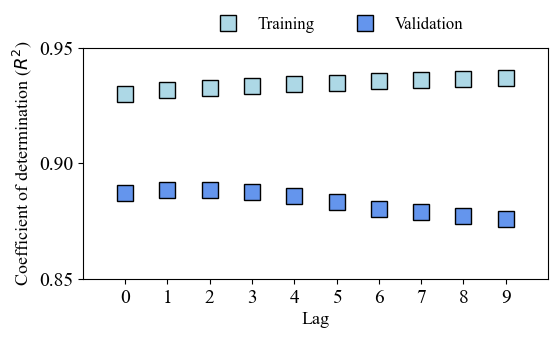

optimal lag: 2
0.9368738580143711
0.8884796166179402
average difference: 0.050916158915450024


In [11]:
# define structures for cross-validations
num_vars = np.shape(df_falcon.drop(list(df_falcon.filter(regex='index')), axis=1))[1] + np.shape(df_imu.drop(list(df_imu.filter(regex='index')), axis=1))[1]-1
gof_cross_validation = pd.DataFrame(columns=["lag","r-sq","mse"]) # empty array for goodness-of-fit measurements
gof_training = pd.DataFrame(columns=["lag","r-sq","mse"]) # empty array for goodness-of-fit measurements

# define the input and output of the machine learning algorithm
features = features[features['User'].isin([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])] # remove user 0 (author of the paper)
Y = features[["Pitch","Yaw","Roll"]]
X = features.drop(["Pitch","Yaw","Roll"], axis=1)

# iterate throught lags
for l in np.arange(lag+1):
    # print("lag "+str(l))
    
    # get only columns up to lag l
    x = X.iloc[:,list(range(0, num_vars*(l+1)))]

    # define training and validation data sets
    X_train = pd.DataFrame(columns=x.keys())
    X_test = pd.DataFrame(columns=x.keys())
    Y_train = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
    Y_test = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
    for id in np.unique(features["User"]):
        X_train = pd.concat([X_train, x[features["User"]==id][:round(K*len(features[features["User"]==id]))]])
        X_test = pd.concat([X_test, x[features["User"]==id][round(K*len(features[features["User"]==id])):]])
        Y_train = pd.concat([Y_train, Y[features["User"]==id][:round(K*len(features[features["User"]==id]))]])
        Y_test = pd.concat([Y_test, Y[features["User"]==id][round(K*len(features[features["User"]==id])):]])
        
    # Train linear regression model for pitch
    model = LinearRegression()
    model.fit(X_train,Y_train[["Pitch"]])
    predictions = model.predict(X_test) 
    
    # Compute R-squared and MSE for cross validation
    gof_cross_validation.loc[len(gof_cross_validation)] = [l, r2_score(Y_test[["Pitch"]], predictions), mean_squared_error(Y_test[["Pitch"]], predictions)]
    
    # Compute R-squared and MSE for training
    predictions = model.predict(X_train)
    gof_training.loc[len(gof_cross_validation)] = [l, r2_score(Y_train[["Pitch"]], predictions), mean_squared_error(Y_train[["Pitch"]], predictions)]

# identify the optimal lag
plt.figure(figsize=(6,3))
x = np.arange(lag+1)
y1 = gof_training['r-sq']
y2 = gof_cross_validation['r-sq']
plt.plot(x, y1, 'bs',markersize=12,markerfacecolor='lightblue',markeredgecolor='black')
plt.plot(x, y2, 'bs',markersize=12,markerfacecolor='cornflowerblue',markeredgecolor='black')
plt.ylabel(r'Coefficient of determination ($R^2$)', fontsize=13, fontname='Times New Roman')
plt.xlabel('Lag', fontsize=13, fontname='Times New Roman')
plt.xticks(np.arange(0,10), fontsize=14, fontname='Times New Roman')
plt.yticks([0.85, 0.9, 0.95], fontsize=14, fontname='Times New Roman')
plt.xlim([-1, lag+1])
plt.ylim([0.85, 0.95])
plt.legend(['Training','Validation'],bbox_to_anchor=(0.85, 1.2), ncol=2, prop={'family':'Times New Roman', 'size':12}, frameon=False) 
# plt.savefig('Figure5a.pdf')
plt.show()

opt_lag = int(gof_cross_validation[gof_cross_validation["r-sq"]==max(gof_cross_validation["r-sq"])]["lag"])
print("optimal lag: "+str(opt_lag))
print(max(gof_training["r-sq"]))
print(max(gof_cross_validation["r-sq"]))
print("average difference: "+str(np.mean(gof_training["r-sq"].reset_index(drop=True)-gof_cross_validation["r-sq"])))


# Apply a linear regression model with optimal lag

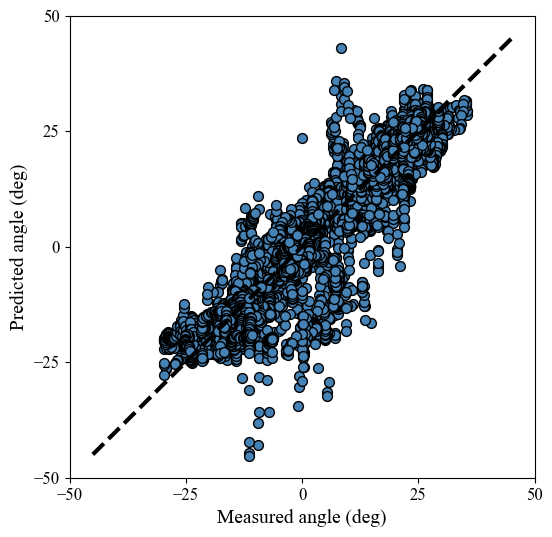

Testing R-squared: 0.8884796166179402
Testing MSE: 25.09649001789393
Range of measured angles:  -29.7374357729918  to  35.4243792649286
Mean of measured angles:  6.027525478513232 +- Pitch    15.001316
dtype: float64
Range of predicted angles:  -45.404872021780875  to  42.96581199875925
Mean of predicted angles:  6.663595391912635 +- 15.725616932762708
Training R-squared: 0.9325823606190333
Training MSE: 19.179628290948372


In [14]:
# define the input and output of the machine learning algorithm with no autoregressive terms
Y = features[["Pitch","Yaw","Roll"]]
X = features.drop(["Pitch","Yaw","Roll"], axis=1)

# get only columns up to optimal lag
x = X.iloc[:,list(range(0, num_vars*(opt_lag+1)))]

# define training and validation data sets
X_train = pd.DataFrame(columns=x.keys())
X_test = pd.DataFrame(columns=x.keys())
Y_train = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
Y_test = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
for id in np.unique(features["User"]):
    X_train = pd.concat([X_train, x[features["User"]==id][:round(K*len(features[features["User"]==id]))]])
    X_test = pd.concat([X_test, x[features["User"]==id][round(K*len(features[features["User"]==id])):]])
    Y_train = pd.concat([Y_train, Y[features["User"]==id][:round(K*len(features[features["User"]==id]))]])
    Y_test = pd.concat([Y_test, Y[features["User"]==id][round(K*len(features[features["User"]==id])):]])

# Train linear regression model
model = LinearRegression()
model.fit(X_train, Y_train[["Pitch"]])
predictions = model.predict(X_test)

# Scatter plot predictions vs. actual angles
plt.figure(figsize=(6,6))
plt.scatter(Y_test[["Pitch"]], predictions, edgecolors='k',c='steelblue',s=50)
plt.plot([-45, 45], [-45, 45], color='black', linestyle='dashed', lw=3)
plt.ylabel('Predicted angle (deg)', fontsize=14, fontname='Times New Roman')
plt.xlabel('Measured angle (deg)', fontsize=14, fontname='Times New Roman')
plt.xticks([-50, -25, 0, 25, 50], fontsize=12, fontname='Times New Roman')
plt.yticks([-50, -25, 0, 25, 50], fontsize=12, fontname='Times New Roman')
plt.ylim([-50, 50])
plt.xlim([-50, 50])
# plt.savefig('Figure5b.pdf')
plt.show()


# Goodness-of-fit in cross-validation
r_squared = r2_score(Y_test[["Pitch"]], predictions)
print("Testing R-squared:", r_squared)
mse = mean_squared_error(Y_test[["Pitch"]], predictions)
print("Testing MSE:", mse)
print("Range of measured angles: ", np.min(Y_test[["Pitch"]]), " to ", np.max(Y_test[["Pitch"]]))
print("Mean of measured angles: ", np.mean(Y_test[["Pitch"]]), "+-", np.std(Y_test[["Pitch"]]))
print("Range of predicted angles: ", np.min(predictions), " to ", np.max(predictions))
print("Mean of predicted angles: ", np.mean(predictions), "+-", np.std(predictions))


# Goodness-of-fit in training
predictions = model.predict(X_train)
r_squared = r2_score(Y_train[["Pitch"]], predictions) # Compute R-squared
print("Training R-squared:", r_squared)
mse = mean_squared_error(Y_train[["Pitch"]], predictions) # Compute MSE
print("Training MSE:", mse)


# Quantify feature importance

Most important features:
0      sin(Yaw1)_Lag:2
1      cos(Yaw1)_Lag:2
2            cos(Yaw1)
3     sin(Roll1)_Lag:2
4          sin(Pitch1)
5    cos(Pitch1)_Lag:2
Name: Feature, dtype: object


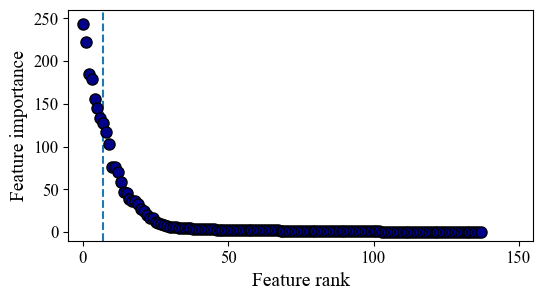

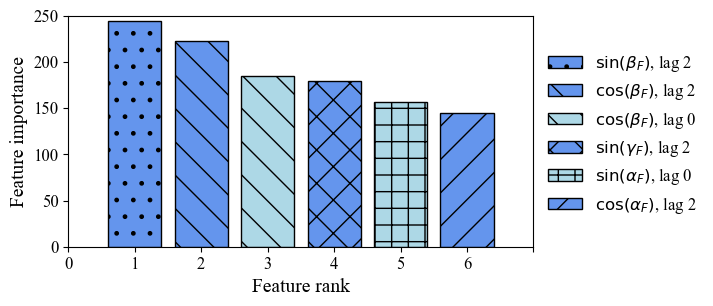

In [16]:
# Get feature names
feature_names = X.iloc[:,list(range(0, num_vars*(opt_lag+1)))].columns

# Get coefficients
coefficients = model.coef_[0,:]

# Create a dataframe for feature importance
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})

# Sort by absolute importance
feature_importance['Abs Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values('Abs Importance', ascending=False).reset_index()

# Identify the most important features
contrib_to_importance = np.cumsum(feature_importance["Abs Importance"]/np.sum(feature_importance["Abs Importance"]))
fraction_contribution = 0.5
num_features = np.where(np.abs(contrib_to_importance-fraction_contribution)==np.min(np.abs(contrib_to_importance-fraction_contribution)))[0][0]
print("Most important features:")
print(feature_importance[0:num_features]["Feature"])

# Display feature importance
x = np.arange(np.shape(feature_importance['Abs Importance'])[0])
y = feature_importance['Abs Importance']
fig = plt.figure(figsize=(6,3))
plt.axvline(x=num_features+1,linestyle="dashed")
plt.plot(x, y, 'o',markersize=8,markerfacecolor='darkblue',markeredgecolor='black')
plt.ylabel('Feature importance', fontsize=14, fontname='Times New Roman')
plt.xlabel('Feature rank', fontsize=14, fontname='Times New Roman')
plt.xticks([0, 50, 100, 150], fontsize=12, fontname='Times New Roman')
plt.yticks([0, 50, 100, 150, 200, 250], fontsize=12, fontname='Times New Roman')
plt.xlim([-5,155])
plt.ylim([-10,260])
# plt.savefig('Figure6a.pdf')
plt.show()

# plot the important features
colors = ["lightblue","","cornflowerblue"] # to be associated with the lag
patterns = [ "/" , "\\" , "+" , "x", "."] # to be associated with the feature
x = np.arange(np.shape(feature_importance['Abs Importance'])[0])[0:num_features]
y = feature_importance['Abs Importance'][0:num_features]
fts = np.unique(feature_importance['Feature'][0:num_features].str.replace('_Lag:2', '').str.replace('_Lag:1', ''))

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
for i in np.arange(num_features):
    d = feature_importance["Feature"][i]
    if ":" in d:
        d = int(feature_importance["Feature"][i][len(feature_importance["Feature"][i])-1])
        f = [x for x,y in zip(patterns,fts==feature_importance['Feature'][i].replace('_Lag:1', '').replace('_Lag:2', '')) if y][0]
    else: 
        d = 0
        f = [x for x,y in zip(patterns,fts==feature_importance['Feature'][i].replace('_Lag:1', '').replace('_Lag:2', '')) if y][0]       
    ax.bar(x[i], y[i], color=colors[d], edgecolor='black', hatch=f)
ax.set_xticklabels(np.arange(num_features+1), fontsize=12, fontname='Times New Roman')    
plt.yticks([0, 50, 100, 150, 200, 250], fontsize=12, fontname='Times New Roman')
plt.ylabel('Feature importance', fontsize=14, fontname='Times New Roman')
plt.xlabel('Feature rank', fontsize=14, fontname='Times New Roman')
plt.xlim([-1,num_features])
plt.ylim([0,250])
plt.legend([r'$\sin(\beta_{F})$, lag 2',r'$\cos(\beta_{F})$, lag 2',r'$\cos(\beta_{F})$, lag 0',r'$\sin(\gamma_{F})$, lag 2',r'$\sin(\alpha_{F})$, lag 0',r'$\cos(\alpha_{F})$, lag 2'],
           bbox_to_anchor=(1, 0.9), ncol=1, prop={'family':'Times New Roman', 'size':12}, frameon=False) 
# plt.savefig('Figure6b.pdf')
plt.show()



# Perform out-of-sample analysis

#### Compute features for out-of-sampe users

In [18]:
# Iterate over each user folder
for user_id, user_folder in enumerate(oos_user_folders, start=0):
    user_data_folder = os.path.join(oos_data_folder, user_folder)
    # print("user "+str(user_id))
    # print(user_data_folder)

    # Load CSV files for each user
    df_falcon = pd.read_csv(os.path.join(user_data_folder, "novint-falcon.csv"))
    df_falcon = df_falcon.rename(columns={'global time': 'Time'}) # rename time column for consistency
    df_imu = pd.read_csv(os.path.join(user_data_folder, "imu.csv"))
    df_angles = pd.read_csv(os.path.join(user_data_folder, "wrist-angles.csv"))
    df_img = pd.read_csv(os.path.join(user_data_folder, "IMG_2 (Instance).csv"))
    
    # Convert time columns to datetime format
    df_falcon['Time'] = pd.to_datetime(df_falcon['Time'].str.strip(), format='%H:%M:%S.%f')
    df_imu['Time'] = pd.to_datetime(df_imu['Time'])
    df_angles['Time'] = pd.to_datetime(df_angles['Time'].str.strip(), format='%I:%M:%S.%f %p')

    # Extract the time from the first row of df_img
    start_time_img = df_img.iloc[0][' time (s)']

    # Find the index of the exact time in df_falcon
    exact_index_falcon = df_falcon[df_falcon[' time (s)'] == start_time_img].index[0]

    # Slice df_falcon from the exact index
    df_falcon = df_falcon.iloc[exact_index_falcon:].reset_index(drop=True)

    # Calculate the time difference for df_angles and df_imu
    time_diff_angles = abs(df_angles['Time'] - df_falcon.iloc[0]['Time'])
    time_diff_imu = abs(df_imu['Time'] - df_falcon.iloc[0]['Time'])

    # Find the index of the minimum time difference
    nearest_index_angles = time_diff_angles.idxmin()
    nearest_index_imu = time_diff_imu.idxmin()
    
    # Slice df_angles and df_imu from the nearest index
    df_angles = df_angles.iloc[nearest_index_angles:].reset_index()
    df_imu = df_imu.iloc[nearest_index_imu:].reset_index()

    # # Number of raw observsations in each dataset
    # print("falcon observations = "+str(np.shape(df_falcon)[0]))
    # print("imu observations = "+str(np.shape(df_imu)[0]))
    
    # Subset only columns relevant for training
    df_falcon = df_falcon.drop([' time (s)',' rotation_x',' rotation_y'], axis=1)
    df_imu.drop(list(df_imu.filter(regex='2')), axis=1, inplace=True) # remove anything with IMU2 that is placed on the back of the hand

    # Downsample the falcon data
    df_falcon_downsampled = pd.DataFrame(columns=df_falcon.keys())
    for ts in np.arange(len(df_angles)):
        min_index = abs(df_angles.iloc[ts]['Time'] - df_falcon['Time']).idxmin()
        df_falcon_downsampled.loc[len(df_falcon_downsampled.index)] = df_falcon.iloc[min_index-2:min_index+3][[' falcon_x',' falcon_y',' falcon_z']].mean()
    df_falcon = pd.concat([df_angles['Time'],df_falcon_downsampled.drop('Time', axis=1).reset_index(drop=True)], axis=1)

    # remove drift from IMU1 yaw
    m,b = np.polyfit(np.arange(np.shape(df_imu)[0]), df_imu["Yaw1"], 1)
    df_imu["Yaw1"] = df_imu["Yaw1"]-(m*np.arange(np.shape(df_imu)[0])+b)    
    
    # apply a median filter on all raw data
    df_angles["Roll"] = signal.medfilt(df_angles["Roll"],kernel_size=window_size)
    df_angles["Pitch"] = signal.medfilt(df_angles["Pitch"],kernel_size=window_size)
    df_angles["Yaw"] = signal.medfilt(df_angles["Yaw"],kernel_size=window_size)
    df_falcon[" falcon_x"] = signal.medfilt(df_falcon[" falcon_x"],kernel_size=window_size)
    df_falcon[" falcon_y"] = signal.medfilt(df_falcon[" falcon_y"],kernel_size=window_size)
    df_falcon[" falcon_z"] = signal.medfilt(df_falcon[" falcon_z"],kernel_size=window_size)
    df_imu["Yaw1"] = signal.medfilt(df_imu["Yaw1"],kernel_size=window_size)
    df_imu["Pitch1"] = signal.medfilt(df_imu["Pitch1"],kernel_size=window_size)
    df_imu["Roll1"] = signal.medfilt(df_imu["Roll1"],kernel_size=window_size)
    df_imu["AccX1"] = signal.medfilt(df_imu["AccX1"],kernel_size=window_size)
    df_imu["AccY1"] = signal.medfilt(df_imu["AccY1"],kernel_size=window_size)
    df_imu["AccZ1"] = signal.medfilt(df_imu["AccZ1"],kernel_size=window_size)
    df_imu["RotX1"] = signal.medfilt(df_imu["RotX1"],kernel_size=window_size)
    df_imu["RotY1"] = signal.medfilt(df_imu["RotY1"],kernel_size=window_size)
    df_imu["RotZ1"] = signal.medfilt(df_imu["RotZ1"],kernel_size=window_size)

    # add time derivatives in falcon data
    df_falcon["falcon_x_dot"] = df_falcon[" falcon_x"]
    df_falcon["falcon_y_dot"] = df_falcon[" falcon_y"]
    df_falcon["falcon_z_dot"] = df_falcon[" falcon_z"]
    for ts in np.arange(((window_size-1)/2),len(df_falcon)-((window_size-1)/2)):
        df_falcon.loc[ts, 'falcon_x_dot'] = (df_falcon[" falcon_x"].loc[ts+((window_size-1)/2)]-df_falcon[" falcon_x"].loc[ts-((window_size-1)/2)])/(df_falcon["Time"].loc[ts+((window_size-1)/2)]-df_falcon["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_falcon.loc[ts, 'falcon_y_dot'] = (df_falcon[" falcon_y"].loc[ts+((window_size-1)/2)]-df_falcon[" falcon_y"].loc[ts-((window_size-1)/2)])/(df_falcon["Time"].loc[ts+((window_size-1)/2)]-df_falcon["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_falcon.loc[ts, 'falcon_z_dot'] = (df_falcon[" falcon_z"].loc[ts+((window_size-1)/2)]-df_falcon[" falcon_z"].loc[ts-((window_size-1)/2)])/(df_falcon["Time"].loc[ts+((window_size-1)/2)]-df_falcon["Time"].loc[ts-((window_size-1)/2)]).total_seconds()

    # add time integrals in IMU data
    df_imu["VelX1"] = df_imu["AccX1"]
    df_imu["VelY1"] = df_imu["AccY1"]
    df_imu["VelZ1"] = df_imu["AccZ1"]    
    for ts in np.arange(((window_size-1)/2),len(df_imu)-((window_size-1)/2)):
        df_imu.loc[ts,'VelX1'] = (df_imu["AccX1"].loc[ts+((window_size-1)/2)]-df_imu["AccX1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_imu.loc[ts,'VelY1'] = (df_imu["AccY1"].loc[ts+((window_size-1)/2)]-df_imu["AccY1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_imu.loc[ts,'VelZ1'] = (df_imu["AccZ1"].loc[ts+((window_size-1)/2)]-df_imu["AccZ1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
    
    # add time integrals in IMU data
    df_imu["PosX1"] = df_imu["AccX1"]
    df_imu["PosY1"] = df_imu["AccY1"]
    df_imu["PosZ1"] = df_imu["AccZ1"]    
    for ts in np.arange(((window_size-1)/2),len(df_imu)-((window_size-1)/2)):
        df_imu.loc[ts,'PosX1'] = (df_imu["VelX1"].loc[ts+((window_size-1)/2)]-df_imu["VelX1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_imu.loc[ts,'PosY1'] = (df_imu["VelY1"].loc[ts+((window_size-1)/2)]-df_imu["VelY1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_imu.loc[ts,'PosZ1'] = (df_imu["VelZ1"].loc[ts+((window_size-1)/2)]-df_imu["VelZ1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()

    # add features from the kinematic model
    df_imu["sin(Pitch1)"] = np.sin(df_imu["Pitch1"].astype(float).apply(math.radians))
    df_imu["sin(Yaw1)"] = np.sin(df_imu["Yaw1"].astype(float).apply(math.radians))
    df_imu["sin(Roll1)"] = np.sin(df_imu["Roll1"].astype(float).apply(math.radians))
    df_imu["cos(Pitch1)"] = np.cos(df_imu["Pitch1"].astype(float).apply(math.radians))
    df_imu["cos(Yaw1)"] = np.cos(df_imu["Yaw1"].astype(float).apply(math.radians))
    df_imu["cos(Roll1)"] = np.cos(df_imu["Roll1"].astype(float).apply(math.radians))
    df_imu["RotX1*sin(Pitch1)"] = df_imu["RotX1"]*df_imu["sin(Pitch1)"]
    df_imu["RotY1*sin(Pitch1)"] = df_imu["RotY1"]*df_imu["sin(Pitch1)"]
    df_imu["RotZ1*sin(Pitch1)"] = df_imu["RotZ1"]*df_imu["sin(Pitch1)"]
    df_imu["RotX1*sin(Yaw1)"] = df_imu["RotX1"]*df_imu["sin(Yaw1)"]
    df_imu["RotY1*sin(Yaw1)"] = df_imu["RotY1"]*df_imu["sin(Yaw1)"]
    df_imu["RotZ1*sin(Yaw1)"] = df_imu["RotZ1"]*df_imu["sin(Yaw1)"]
    df_imu["RotX1*sin(Roll1)"] = df_imu["RotX1"]*df_imu["sin(Roll1)"]
    df_imu["RotY1*sin(Roll1)"] = df_imu["RotY1"]*df_imu["sin(Roll1)"]
    df_imu["RotZ1*sin(Roll1)"] = df_imu["RotZ1"]*df_imu["sin(Roll1)"]
    df_imu["RotX1*cos(Pitch1)"] = df_imu["RotX1"]*df_imu["cos(Pitch1)"]
    df_imu["RotY1*cos(Pitch1)"] = df_imu["RotY1"]*df_imu["cos(Pitch1)"]
    df_imu["RotZ1*cos(Pitch1)"] = df_imu["RotZ1"]*df_imu["cos(Pitch1)"]
    df_imu["RotX1*cos(Yaw1)"] = df_imu["RotX1"]*df_imu["cos(Yaw1)"]
    df_imu["RotY1*cos(Yaw1)"] = df_imu["RotY1"]*df_imu["cos(Yaw1)"]
    df_imu["RotZ1*cos(Yaw1)"] = df_imu["RotZ1"]*df_imu["cos(Yaw1)"]
    df_imu["RotX1*cos(Roll1)"] = df_imu["RotX1"]*df_imu["cos(Roll1)"]
    df_imu["RotY1*cos(Roll1)"] = df_imu["RotY1"]*df_imu["cos(Roll1)"]
    df_imu["RotZ1*cos(Roll1)"] = df_imu["RotZ1"]*df_imu["cos(Roll1)"]
    df_imu["arctan"] = np.arctan(np.nan_to_num(((-df_imu["VelX1"]+df_falcon["falcon_x_dot"]-L*df_imu["RotY1"]*df_imu["sin(Pitch1)"])/(df_imu["VelY1"]-df_falcon["falcon_y_dot"]+L*df_imu["RotY1"]*df_imu["cos(Pitch1)"])).apply(math.radians)))+df_imu["Pitch1"]

    # apply a median filter on computed values
    df_falcon["falcon_x_dot"] = signal.medfilt(df_falcon["falcon_x_dot"],kernel_size=window_size)
    df_falcon["falcon_y_dot"] = signal.medfilt(df_falcon["falcon_y_dot"],kernel_size=window_size)
    df_falcon["falcon_z_dot"] = signal.medfilt(df_falcon["falcon_z_dot"],kernel_size=window_size)
    df_imu["VelX1"] = signal.medfilt(df_imu["VelX1"],kernel_size=window_size)
    df_imu["VelY1"] = signal.medfilt(df_imu["VelY1"],kernel_size=window_size)
    df_imu["VelZ1"] = signal.medfilt(df_imu["VelZ1"],kernel_size=window_size)
    df_imu["PosX1"] = signal.medfilt(df_imu["PosX1"],kernel_size=window_size)
    df_imu["PosY1"] = signal.medfilt(df_imu["PosY1"],kernel_size=window_size)
    df_imu["PosZ1"] = signal.medfilt(df_imu["PosZ1"],kernel_size=window_size)
    df_imu["sin(Pitch1)"] = signal.medfilt(df_imu["sin(Pitch1)"],kernel_size=window_size)
    df_imu["sin(Yaw1)"] = signal.medfilt(df_imu["sin(Yaw1)"],kernel_size=window_size)
    df_imu["sin(Roll1)"] = signal.medfilt(df_imu["sin(Roll1)"],kernel_size=window_size)
    df_imu["cos(Pitch1)"] = signal.medfilt(df_imu["cos(Pitch1)"],kernel_size=window_size)
    df_imu["cos(Yaw1)"] = signal.medfilt(df_imu["cos(Yaw1)"],kernel_size=window_size)
    df_imu["cos(Roll1)"] = signal.medfilt(df_imu["cos(Roll1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Pitch1)"] = signal.medfilt(df_imu["RotX1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Pitch1)"] = signal.medfilt(df_imu["RotY1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Pitch1)"] = signal.medfilt(df_imu["RotZ1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Yaw1)"] = signal.medfilt(df_imu["RotX1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Yaw1)"] = signal.medfilt(df_imu["RotY1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Yaw1)"] = signal.medfilt(df_imu["RotZ1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Roll1)"] = signal.medfilt(df_imu["RotX1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Roll1)"] = signal.medfilt(df_imu["RotY1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Roll1)"] = signal.medfilt(df_imu["RotZ1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Pitch1)"] = signal.medfilt(df_imu["RotX1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Pitch1)"] = signal.medfilt(df_imu["RotY1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Pitch1)"] = signal.medfilt(df_imu["RotZ1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Yaw1)"] = signal.medfilt(df_imu["RotX1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Yaw1)"] = signal.medfilt(df_imu["RotY1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Yaw1)"] = signal.medfilt(df_imu["RotZ1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Roll1)"] = signal.medfilt(df_imu["RotX1*cos(Roll1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Roll1)"] = signal.medfilt(df_imu["RotY1*cos(Roll1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Roll1)"] = signal.medfilt(df_imu["RotZ1*cos(Roll1)"],kernel_size=window_size)
    df_imu["arctan"] = signal.medfilt(df_imu["arctan"],kernel_size=window_size)

    # change the time colmns to index to merge time series into a single dataframe
    df_angles = df_angles.set_index(['Time'])
    df_falcon = df_falcon.set_index(['Time'])
    df_imu = df_imu.set_index(['Time'])
    
    # # print the lenth of the interaction in time
    # print("falcon observations = "+str(np.shape(df_falcon)[0]))
    # print("duration = "+str(df_imu.reset_index()["Time"][np.shape(df_imu)[0]-1]-df_imu.reset_index()["Time"][0]))

    # Merge time series into a single dataframe
    df_data = pd.merge(df_angles, df_falcon, left_index=True, right_index=True)
    df_data = pd.merge(df_data, df_imu, left_index=True, right_index=True)

    # Revert index back to numerics
    df_data = df_data.reset_index(drop=True)
    
    # Lag the merged data
    df_data = time_embed(df_data, lag)

    # remove rows with NaN values
    df_data = df_data.dropna()

    # Add user ID column
    df_data['User'] = user_id

    # Append to the list of DataFrames
    dfs.append(df_data)

# Convert the dataframes into a pandas dataframe
oos_features = pd.concat(dfs)

# remove irrelevant columns
oos_features.drop(list(oos_features.filter(regex='index')), axis=1, inplace=True)
oos_features.drop(list(oos_features.filter(regex='Roll_Lag:')), axis=1, inplace=True)
oos_features.drop(list(oos_features.filter(regex='Pitch_Lag:')), axis=1, inplace=True)
oos_features.drop(list(oos_features.filter(regex='Yaw_Lag:')), axis=1, inplace=True)
oos_features.drop(list(oos_features.filter(regex='Unnamed')), axis=1, inplace=True)

# # Save merged data to a new CSV file
# oos_features.to_csv('oos_features.csv')


#### Apply model on out-of-sample users

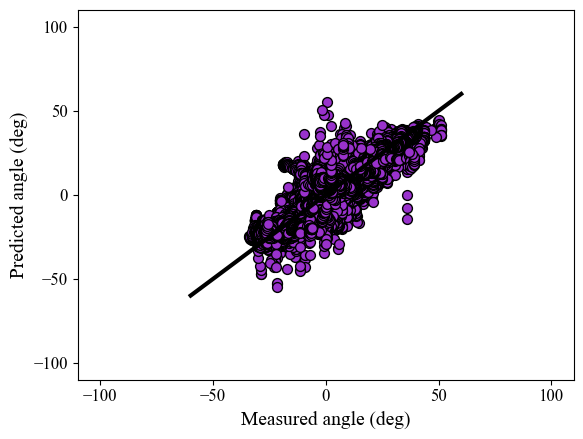

Testing R-squared: 0.8973453593089766
Testing MSE: 25.604157259743058


In [20]:
# define the input and output of the machine learning algorithm with no autoregressive terms
Y = oos_features[["Pitch","Yaw","Roll"]]
X = oos_features.drop(["Pitch","Yaw","Roll"], axis=1)

# get only columns within optimal lag
x = X.iloc[:,list(range(0, num_vars*(opt_lag+1)))]

# Train linear regression model
predictions = model.predict(x)

# Scatter plot predictions vs. actual angles
plt.scatter(Y[["Pitch"]], predictions, edgecolors='k',c='darkorchid',s=50)
plt.plot([-60, 60], [-60, 60], color='black', lw=3)
plt.ylabel('Predicted angle (deg)', fontsize=14, fontname='Times New Roman')
plt.xlabel('Measured angle (deg)', fontsize=14, fontname='Times New Roman')
plt.xticks([-100, -50, 0, 50, 100], fontsize=12, fontname='Times New Roman')
plt.yticks([-100, -50, 0, 50, 100], fontsize=12, fontname='Times New Roman')
plt.ylim([-110, 110])
plt.xlim([-110, 110])
plt.show()

# Goodness-of-fit
r_squared = r2_score(Y[["Pitch"]], predictions)
print("Testing R-squared:", r_squared)
mse = mean_squared_error(Y[["Pitch"]], predictions)
print("Testing MSE:", mse)


# Train a ridge regression model with various regularization terms

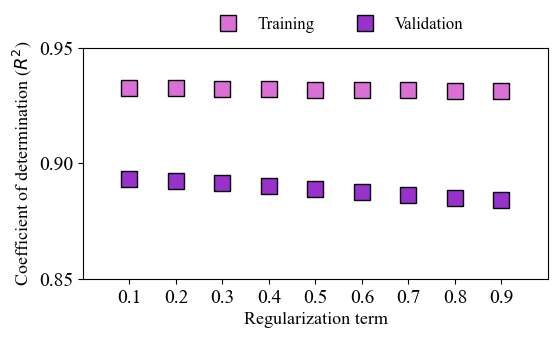

optimal regularization term: 0
0.9324679384078342
0.8931947495361912


In [22]:
# define dataframes for goodness-of-fit
gof_cross_validation = pd.DataFrame(columns=["alpha","r-sq","mse"]) # empty array for calculating mean squared error
gof_training = pd.DataFrame(columns=["alpha","r-sq","mse"]) # empty array for calculating mean squared error

# define the input and output of the machine learning algorithm
Y = features[["Pitch","Yaw","Roll"]]
X = features.drop(["Pitch","Yaw","Roll"], axis=1)

# get only columns up to optimal lag
x = X.iloc[:,list(range(0, num_vars*(opt_lag+1)))]

# define training and validation data sets
X_train = pd.DataFrame(columns=x.keys())
X_test = pd.DataFrame(columns=x.keys())
Y_train = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
Y_test = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
for id in np.unique(features["User"]):
    X_train = pd.concat([X_train, x[features["User"]==id][:round(K*len(features[features["User"]==id]))]])
    X_test = pd.concat([X_test, x[features["User"]==id][round(K*len(features[features["User"]==id])):]])
    Y_train = pd.concat([Y_train, Y[features["User"]==id][:round(K*len(features[features["User"]==id]))]])
    Y_test = pd.concat([Y_test, Y[features["User"]==id][round(K*len(features[features["User"]==id])):]])

for a in np.arange(1,10)/10:
    # print("alpha = "+str(a))

    # Train ridge regression model
    model = linear_model.Ridge(alpha=a)
    model.fit(X_train, Y_train[["Pitch"]])
    predictions = model.predict(X_test)
    
    # Compute R-squared and MSE for cross validation
    gof_cross_validation.loc[len(gof_cross_validation)] = [a, r2_score(Y_test[["Pitch"]], predictions), mean_squared_error(Y_test[["Pitch"]], predictions)]
    
    # Compute R-squared and MSE for training
    predictions = model.predict(X_train)
    gof_training.loc[len(gof_cross_validation)] = [a, r2_score(Y_train[["Pitch"]], predictions), mean_squared_error(Y_train[["Pitch"]], predictions)]

# identify the optimal regularization term
plt.figure(figsize=(6,3))
x = np.arange(1,10)/10
y1 = gof_training['r-sq']
y2 = gof_cross_validation['r-sq']
plt.plot(x, y1, 'bs',markersize=12,markerfacecolor='orchid',markeredgecolor='black')
plt.plot(x, y2, 'bs',markersize=12,markerfacecolor='darkorchid',markeredgecolor='black')
plt.ylabel(r'Coefficient of determination ($R^2$)', fontsize=13, fontname='Times New Roman')
plt.xlabel('Regularization term', fontsize=13, fontname='Times New Roman')
plt.xticks(np.arange(1,10)/10, fontsize=14, fontname='Times New Roman')
plt.yticks([0.85, 0.9, 0.95], fontsize=14, fontname='Times New Roman')
plt.xlim([0, 1])
plt.ylim([0.85, 0.95])
plt.legend(['Training','Validation'],bbox_to_anchor=(0.85, 1.2), ncol=2, prop={'family':'Times New Roman', 'size':12}, frameon=False) 
# plt.savefig('Figure7a.pdf')
plt.show()

opt_reg = int(gof_cross_validation[gof_cross_validation["r-sq"]==max(gof_cross_validation["r-sq"])]["alpha"])
print("optimal regularization term: "+str(opt_reg))
print(max(gof_training["r-sq"]))
print(max(gof_cross_validation["r-sq"]))

# Train a lasso regression model with various regularization terms

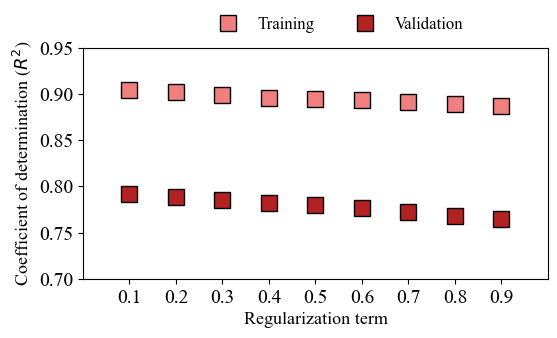

optimal regularization term: 0
0.9037879175521923
0.792109876483848


In [24]:
# define dataframes for goodness-of-fit
gof_cross_validation = pd.DataFrame(columns=["alpha","r-sq","mse"]) # empty array for calculating mean squared error
gof_training = pd.DataFrame(columns=["alpha","r-sq","mse"]) # empty array for calculating mean squared error

# define the input and output of the machine learning algorithm
Y = features[["Pitch","Yaw","Roll"]]
X = features.drop(["Pitch","Yaw","Roll"], axis=1)

# get only columns up to optimal lag
x = X.iloc[:,list(range(0, num_vars*(opt_lag+1)))]

# define training and validation data sets
X_train = pd.DataFrame(columns=x.keys())
X_test = pd.DataFrame(columns=x.keys())
Y_train = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
Y_test = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
for id in np.unique(features["User"]):
    X_train = pd.concat([X_train, x[features["User"]==id][:round(K*len(features[features["User"]==id]))]])
    X_test = pd.concat([X_test, x[features["User"]==id][round(K*len(features[features["User"]==id])):]])
    Y_train = pd.concat([Y_train, Y[features["User"]==id][:round(K*len(features[features["User"]==id]))]])
    Y_test = pd.concat([Y_test, Y[features["User"]==id][round(K*len(features[features["User"]==id])):]])

for a in np.arange(1,10)/10:
    # print("alpha = "+str(a))

    # Train ridge regression model
    model = linear_model.Lasso(alpha=a)
    model.fit(X_train, Y_train[["Pitch"]])
    predictions = model.predict(X_test)
    
    # Compute R-squared and MSE for cross validation
    gof_cross_validation.loc[len(gof_cross_validation)] = [a, r2_score(Y_test[["Pitch"]], predictions), mean_squared_error(Y_test[["Pitch"]], predictions)]
    
    # Compute R-squared and MSE for training
    predictions = model.predict(X_train)
    gof_training.loc[len(gof_cross_validation)] = [a, r2_score(Y_train[["Pitch"]], predictions), mean_squared_error(Y_train[["Pitch"]], predictions)]

# identify the optimal regularization term
plt.figure(figsize=(6,3))
x = np.arange(1,10)/10
y1 = gof_training['r-sq']
y2 = gof_cross_validation['r-sq']
plt.plot(x, y1, 'bs',markersize=12,markerfacecolor='lightcoral',markeredgecolor='black')
plt.plot(x, y2, 'bs',markersize=12,markerfacecolor='firebrick',markeredgecolor='black')
plt.ylabel(r'Coefficient of determination ($R^2$)', fontsize=13, fontname='Times New Roman')
plt.xlabel('Regularization term', fontsize=13, fontname='Times New Roman')
plt.xticks(np.arange(1,10)/10, fontsize=14, fontname='Times New Roman')
plt.yticks([0.7, 0.75, 0.8, 0.85, 0.9, 0.95], fontsize=14, fontname='Times New Roman')
plt.xlim([0, 1])
plt.ylim([0.7, 0.95])
plt.legend(['Training','Validation'],bbox_to_anchor=(0.85, 1.2), ncol=2, prop={'family':'Times New Roman', 'size':12}, frameon=False) 
# plt.savefig('Figure7b.pdf')
plt.show()

opt_reg = int(gof_cross_validation[gof_cross_validation["r-sq"]==max(gof_cross_validation["r-sq"])]["alpha"])
print("optimal regularization term: "+str(opt_reg))
print(max(gof_training["r-sq"]))
print(max(gof_cross_validation["r-sq"]))

# Train a decision tree model with various depths

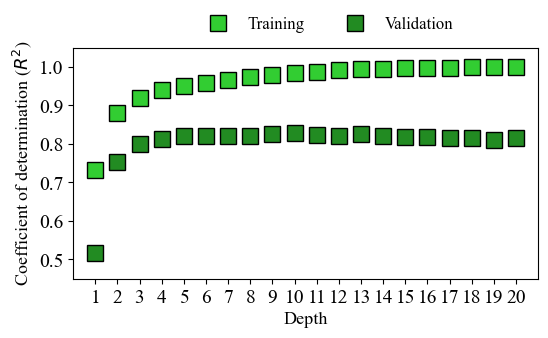

optimal depth: 10
0.9994331224501533
0.8289168974937788


In [25]:
# define structures cross-validations
gof_cross_validation = pd.DataFrame(columns=["depth","r-sq","mse"]) # empty array for goodness-of-fit measurements
gof_training = pd.DataFrame(columns=["depth","r-sq","mse"]) # empty array for goodness-of-fit measurements

# define the input and output of the machine learning algorithm
Y = features[["Pitch","Yaw","Roll"]]
X = features.drop(["Pitch","Yaw","Roll"], axis=1)

# get only columns without lags
x = X.iloc[:,list(range(0, num_vars*(opt_lag+1)))]

# define training and validation data sets
X_train = pd.DataFrame(columns=x.keys())
X_test = pd.DataFrame(columns=x.keys())
Y_train = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
Y_test = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
for id in np.unique(features["User"]):
    X_train = pd.concat([X_train, x[features["User"]==id][:round(K*len(features[features["User"]==id]))]])
    X_test = pd.concat([X_test, x[features["User"]==id][round(K*len(features[features["User"]==id])):]])
    Y_train = pd.concat([Y_train, Y[features["User"]==id][:round(K*len(features[features["User"]==id]))]])
    Y_test = pd.concat([Y_test, Y[features["User"]==id][round(K*len(features[features["User"]==id])):]])

for d in np.arange(1,21):
    # print("depth = "+str(d))
        
    # Train linear regression model for pitch
    model = DecisionTreeRegressor(max_depth=d)
    model.fit(X_train, Y_train[["Pitch"]])
    predictions = model.predict(X_test)
    
    # Compute R-squared and MSE for cross validation
    gof_cross_validation.loc[len(gof_cross_validation)] = [d, r2_score(Y_test["Pitch"], predictions), mean_squared_error(Y_test["Pitch"], predictions)]
    
    # Compute R-squared and MSE for training
    predictions = model.predict(X_train)
    gof_training.loc[len(gof_cross_validation)] = [d, r2_score(Y_train[["Pitch"]], predictions), mean_squared_error(Y_train[["Pitch"]], predictions)]

# identify the optimal depth
plt.figure(figsize=(6,3))
x = np.arange(1,21)
y1 = gof_training['r-sq']
y2 = gof_cross_validation['r-sq']
plt.plot(x, y1, 'bs',markersize=12,markerfacecolor='limegreen',markeredgecolor='black')
plt.plot(x, y2, 'bs',markersize=12,markerfacecolor='forestgreen',markeredgecolor='black')
plt.ylabel(r'Coefficient of determination ($R^2$)', fontsize=13, fontname='Times New Roman')
plt.xlabel('Depth', fontsize=13, fontname='Times New Roman')
plt.xticks(np.arange(1,21), fontsize=14, fontname='Times New Roman')
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1], fontsize=14, fontname='Times New Roman')
plt.xlim([0, 21])
plt.ylim([0.45, 1.05])
plt.legend(['Training','Validation'],bbox_to_anchor=(0.85, 1.2), ncol=2, prop={'family':'Times New Roman', 'size':12}, frameon=False) 
# plt.savefig('Figure7c.pdf')
plt.show()

opt_depth = int(gof_cross_validation[gof_cross_validation["r-sq"]==max(gof_cross_validation["r-sq"])]["depth"])
print("optimal depth: "+str(opt_depth))
print(max(gof_training["r-sq"]))
print(max(gof_cross_validation["r-sq"]))